In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import os
import pathlib

import joblib
import matplotlib.pyplot as plt
import motorlab as ml
import numpy as np
import seaborn as sns
import torch
import yaml

In [3]:
os.chdir(pathlib.Path().resolve().parent)

In [4]:
runs = {
    "all": 20250820203533,
    "loose": 20250820204845,
    "medium": 20250820210428,
    "strict": 20250820211643,
    "draconian": 20250820212632,
}

In [5]:
ARTIFACTS_DIR = pathlib.Path("artifacts/poses_to_location/")
DATA_DIR = pathlib.Path("data")
OLD_GBYK = True
EXPERIMENT_NAME = "old_gbyk" if OLD_GBYK else "gbyk"
EXPERIMENT_DIR = DATA_DIR / EXPERIMENT_NAME
PREFIX = "old_" if OLD_GBYK else ""
RUN = "draconian"
RUN_DIR = ARTIFACTS_DIR / str(runs[RUN])

In [6]:
config_path = RUN_DIR / "config.yml"
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

In [7]:
config

{'artifacts_dir': 'artifacts/',
 'data': {'dataloader': {'batch_size': 64, 'max_length': 80, 'min_length': 80},
  'dataset': {'concat_input': True,
   'concat_output': True,
   'input_dims': {'bex_20230623_denoised': {'poses': 14},
    'ken_20230614_denoised': {'poses': 33},
    'ken_20230618_denoised': {'poses': 15}},
   'input_modalities': ['poses'],
   'output_dims': {'bex_20230623_denoised': {'location': 2},
    'ken_20230614_denoised': {'location': 2},
    'ken_20230618_denoised': {'location': 2}},
   'output_modalities': ['location'],
   'stride': 20},
  'dir': 'data',
  'intervals': {'balance_intervals': False,
   'include_homing': True,
   'include_sitting': True,
   'include_trial': True},
  'modalities': {'kinematics': {'representation': 'com_vec'},
   'location': {'representation': 'com'},
   'poses': {'coordinates': 'egocentric',
    'project_to_pcs': 'draconian',
    'representation': 'draconian',
    'skeleton_type': 'normal'},
   'spike_count': {'brain_areas': 'all'},
  

In [8]:
checkpoint_state = ml.utils.load_checkpoint(RUN_DIR)
model = ml.models.create(
    config["model"],
    config["data"]["dataset"]["output_dims"],
)
model.load_state_dict(checkpoint_state["model"])

EmbeddingCoreReadoutModel(
  (embedding): EmbeddingLayer(
    (embeddings): ModuleDict(
      (bex_20230623_denoised): ModuleDict(
        (poses): LazyLinear(in_features=0, out_features=128, bias=True)
      )
      (ken_20230614_denoised): ModuleDict(
        (poses): LazyLinear(in_features=0, out_features=128, bias=True)
      )
      (ken_20230618_denoised): ModuleDict(
        (poses): LazyLinear(in_features=0, out_features=128, bias=True)
      )
    )
  )
  (core): CoreLayer(
    (core): FCModule(
      (fc): ModuleList(
        (0): Sequential(
          (0): LazyLinear(in_features=0, out_features=128, bias=True)
          (1): GELU(approximate='none')
        )
        (1-2): 2 x Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): GELU(approximate='none')
        )
      )
    )
  )
  (readout): ReadoutLayer(
    (readouts): ModuleDict(
      (bex_20230623_denoised): ModuleDict(
        (location): LazyLinear(in_features=0, out_featur

<All keys matched successfully>

In [9]:
test_dls = ml.data.create_dataloaders_sessions(
    sessions=config["sessions"],
    experiment=EXPERIMENT_NAME,
    cfg=config["data"],
    query={"tier": "test"},
    preprocess_cfg=False,
)

/Users/caio/dev/motorlab/motorlab/poses.py:30: RuntimeWarning: Mean of empty slice
  poses_data = np.nanmean(poses_data, axis=1)
/Users/caio/dev/motorlab/motorlab/poses.py:54: RuntimeWarning: Mean of empty slice
  com_data = np.nanmean(com_data, axis=1)
/Users/caio/dev/motorlab/motorlab/poses.py:30: RuntimeWarning: Mean of empty slice
  poses_data = np.nanmean(poses_data, axis=1)
/Users/caio/dev/motorlab/motorlab/poses.py:54: RuntimeWarning: Mean of empty slice
  com_data = np.nanmean(com_data, axis=1)


In [10]:
baseline = dict()

with torch.no_grad():
    for session in config["sessions"]:
        losses = []
        for x_interval, y_interval in test_dls[session]:
            pred = model(x_interval, session)
            y_numpy = y_interval["location"].cpu().numpy()
            pred_numpy = pred["location"].cpu().numpy()
            losses.append(np.sqrt(np.mean((y_numpy - pred_numpy) ** 2)))
        baseline[session] = np.mean(losses)

In [11]:
ml.utils.fix_seed(0)
pcs_importance = dict()
n_iters = 1  # how many times i'll shuffle

with torch.no_grad():
    for session in config["sessions"]:
        session_losses = []
        for x_interval, y_interval in test_dls[session]:
            x_poses = x_interval["poses"]
            n_pcs = x_poses.shape[-1]
            n_samples = x_poses.shape[1]
            losses = np.zeros((n_pcs, n_iters))
            for pc in range(n_pcs):
                for i in range(n_iters):
                    shuffled = x_poses.clone()
                    idx = torch.randperm(n_samples)
                    shuffled[..., :, pc] = shuffled[..., idx, pc]
                    pred = model({"poses": shuffled}, session)
                    y_numpy = y_interval["location"].cpu().numpy()
                    pred_numpy = pred["location"].cpu().numpy()
                    losses[pc, i] = np.sqrt(
                        np.mean((y_numpy - pred_numpy) ** 2)
                    )
            session_losses.append(np.mean(losses, axis=1))
        pcs_importance[session] = np.mean(np.stack(session_losses), axis=0)

In [12]:
results_dict = {"session": [], "pc": [], "rmse": []}

for session in pcs_importance:
    for i in range(len(pcs_importance[session])):
        results_dict["session"].append(session)
        results_dict["pc"].append(i)
        results_dict["rmse"].append(pcs_importance[session][i])

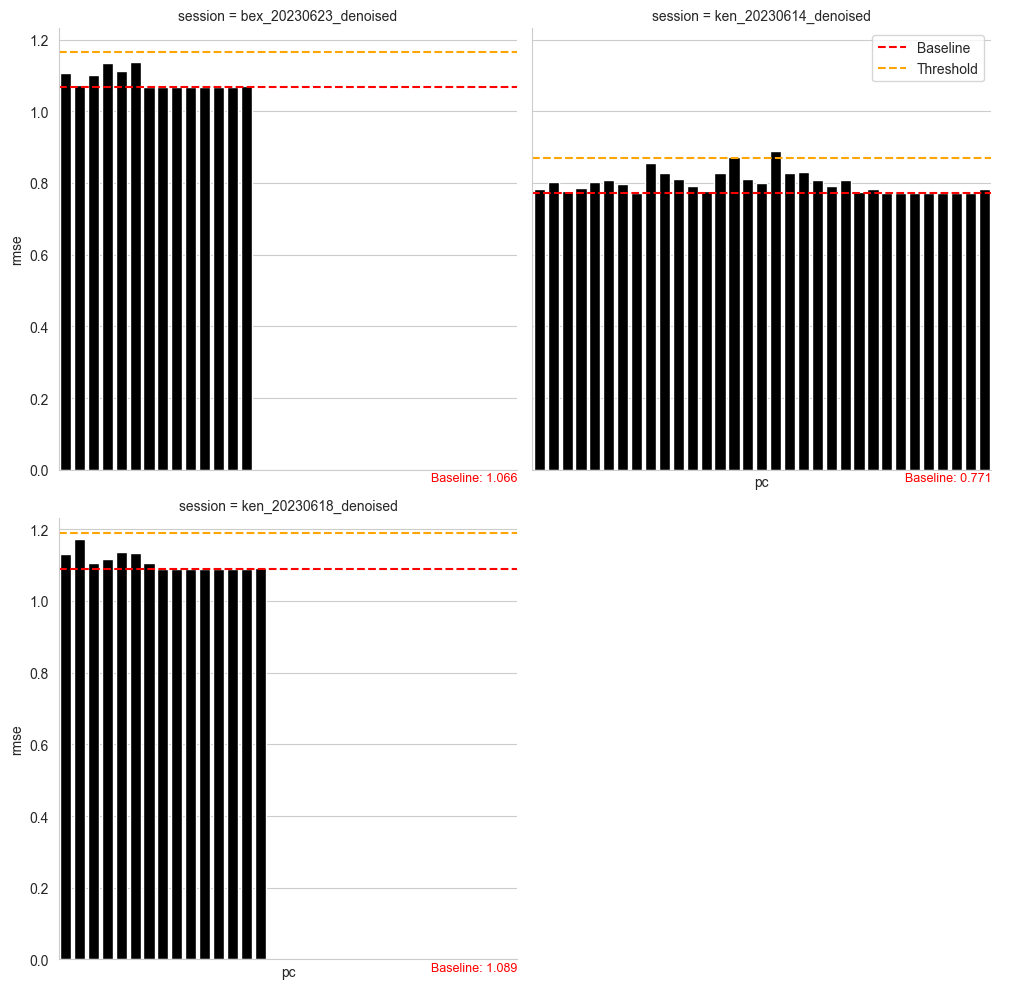

In [13]:
%matplotlib inline
sns.set_style("whitegrid")


g = sns.catplot(
    data=results_dict,
    x="pc",
    y="rmse",
    col="session",
    col_wrap=2,
    kind="bar",
    color="black",
)

threshold = 0.1

for ax in g.axes.flatten():
    title = ax.get_title()
    session = title.split(" = ")[-1]
    ax.text(
        1.0,
        -0.04,
        f"Baseline: {baseline[session]:.3f}",
        color="red",
        ha="right",
        va="bottom",
        fontsize=9,
        transform=ax.get_yaxis_transform(),
    )
    ax.axhline(
        y=baseline[session], color="red", linestyle="--", label="Baseline"
    )
    ax.axhline(
        y=baseline[session] + threshold,
        color="orange",
        linestyle="--",
        label="Threshold",
    )

g.axes.flatten()[1].legend(loc="upper right")
g.set(xticks=[])
plt.tight_layout()
plt.savefig(
    f"plots/analysis_pca/{PREFIX}barplot_rmse_pcs_baseline_{RUN}.svg",
    bbox_inches="tight",
)

In [ ]:
pcs_to_exclude = dict()

print("Summary of Principal Component Importance Analysis")


print(f"\nUsing importance threshold: {threshold:.2f}")
print("-" * 79)
for session, rmses in pcs_importance.items():
    rmses = np.array(rmses)
    session_baseline = baseline[session]

    important_indices = np.where(rmses >= threshold + session_baseline)[0]
    pcs_to_exclude[session] = important_indices.tolist()

    print(f"Session: {session}")
    print(f"Baseline RMSE: {session_baseline:.4f}")
    print(
        f"Important PCs (n={len(important_indices)}): {important_indices.tolist()}"
    )
    print("=" * 79)

Summary of Principal Component Importance Analysis

Using importance threshold: 0.10
-------------------------------------------------------------------------------
Session: bex_20230623_denoised
Baseline RMSE: 0.8624
Important PCs (n=9): [0, 2, 4, 6, 8, 9, 10, 11, 14]
Session: ken_20230614_denoised
Baseline RMSE: 0.5914
Important PCs (n=4): [0, 2, 3, 6]
Session: ken_20230618_denoised
Baseline RMSE: 0.7525
Important PCs (n=11): [2, 3, 4, 5, 6, 7, 8, 9, 11, 16, 17]


In [ ]:
repr_map = {
    "all": "loose",
    "loose": "medium",
    "medium": "strict",
    "strict": "draconian",
}

In [ ]:
coordinates = config["data"]["modalities"]["poses"]["coordinates"]

In [ ]:
for session in config["sessions"]:
    poses_meta_dir = EXPERIMENT_DIR / session / "poses" / "meta"
    pca = joblib.load(poses_meta_dir / f"pcs_{coordinates}_{RUN}.pkl")
    new_pca = copy.deepcopy(pca)
    idxs_to_include = [
        i
        for i in range(len(pca.components_))
        if i not in pcs_to_exclude[session]
    ]
    new_pca.components_ = pca.components_[idxs_to_include]
    new_pca.explained_variance_ = pca.explained_variance_[idxs_to_include]
    new_pca.explained_variance_ratio_ = pca.explained_variance_ratio_[
        idxs_to_include
    ]
    new_pca.n_components_ = len(idxs_to_include)
    if hasattr(pca, "singular_values_"):
        new_pca.singular_values_ = pca.singular_values_[idxs_to_include]
    joblib.dump(
        new_pca,
        poses_meta_dir / f"pcs_{coordinates}_{repr_map[RUN]}.pkl",
    )